In [ ]:
import pandas as pd
import urllib
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import os
import time
from PIL import Image

from keras.applications.vgg16 import VGG16
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Input, Dropout
from keras.models import Model, Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/number-plate/Indian Number Plates

/content/drive/MyDrive/number-plate/Indian Number Plates


In [ ]:
df = pd.read_csv("license_train.csv") #read dataset csv


In [ ]:
df["image_name"] = df["image_name"] + ".jpeg"
df.drop(["image_width", "image_height"], axis=1, inplace=True)
df.head()

,image_name,top_x,top_y,bottom_x,bottom_y
0,car_0.jpeg,0.722084,0.587983,0.868486,0.688841
1,car_1.jpeg,0.161943,0.850780,0.582996,1.000000
2,car_2.jpeg,0.082000,0.697452,0.230000,0.828025
3,car_3.jpeg,0.434000,0.667377,0.718000,0.765458
4,car_4.jpeg,0.208791,0.390764,0.865135,0.984014


In [ ]:

a=list(range(220,len(df)))
#taking few data for testing
data_for_train=df.drop(a,axis=0)

In [ ]:
data_for_train.head()

,image_name,top_x,top_y,bottom_x,bottom_y
0,car_0.jpeg,0.722084,0.587983,0.868486,0.688841
1,car_1.jpeg,0.161943,0.850780,0.582996,1.000000
2,car_2.jpeg,0.082000,0.697452,0.230000,0.828025
3,car_3.jpeg,0.434000,0.667377,0.718000,0.765458
4,car_4.jpeg,0.208791,0.390764,0.865135,0.984014


In [ ]:
a=list(range(0,220))

In [ ]:
#taking few data for testing
test_data=df.drop(a,axis=0)

In [ ]:
test_data.head()

,image_name,top_x,top_y,bottom_x,bottom_y
220,car_220.jpeg,0.131579,0.578788,0.464115,0.721212
221,car_221.jpeg,0.216783,0.737778,0.694639,0.902222
222,car_222.jpeg,0.282000,0.663664,0.702000,0.819820
223,car_223.jpeg,0.272000,0.585075,0.696000,0.829851
224,car_224.jpeg,0.104803,0.257143,0.816594,0.742857


In [ ]:
WIDTH = 224
HEIGHT = 224
CHANNEL = 3

In [ ]:
%cd /content/drive/MyDrive/number-plate/

/content/drive/MyDrive/number-plate


In [ ]:
%ls

 anpr_yolov5/     Indian/                  Indian_Number_plates.json
 api-detection/  'Indian Number Plates'/   scratch-yolov5/


In [ ]:
def view_car(index):
    image = cv2.imread("Indian/" + df["image_name"].iloc[index])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, dsize=(WIDTH, HEIGHT))
    tx = int(df["top_x"].iloc[index] * WIDTH)
    ty = int(df["top_y"].iloc[index] * HEIGHT)
    bx = int(df["bottom_x"].iloc[index] * WIDTH)
    by = int(df["bottom_y"].iloc[index] * HEIGHT)

    image = cv2.rectangle(image, (tx, ty), (bx, by), (0, 0, 255), 3)
    plt.imshow(image)
    plt.show()

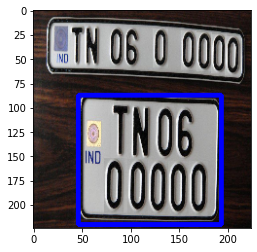

In [ ]:
view_car(4)

In [ ]:
data_generator = ImageDataGenerator(rescale=1./255, validation_split=0.1)

In [ ]:
train_generator = data_generator.flow_from_dataframe(
    data_for_train,
    directory="Indian/",
    x_col="image_name",
    y_col=["top_x", "top_y", "bottom_x", "bottom_y"],
    target_size=(WIDTH, HEIGHT),
    batch_size=32, 
    class_mode="raw",
    subset="training")

Found 198 validated image filenames.


In [ ]:
validation_generator = data_generator.flow_from_dataframe(
    data_for_train,
    directory="Indian/",
    x_col="image_name",
    y_col=["top_x", "top_y", "bottom_x", "bottom_y"],
    target_size=(WIDTH, HEIGHT),
    batch_size=32, 
    class_mode="raw",
    subset="validation")

Found 22 validated image filenames.


In [ ]:
test_generator = data_generator.flow_from_dataframe(
    test_data,
    directory="Indian/",
    x_col="image_name",
    y_col=["top_x", "top_y", "bottom_x", "bottom_y"],
    target_size=(WIDTH, HEIGHT),
    batch_size=32, 
    class_mode="raw",
    )

Found 17 validated image filenames.


In [ ]:
model = Sequential()
model.add(VGG16(weights="imagenet", include_top=False, input_shape=(HEIGHT, WIDTH, CHANNEL)))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(4, activation="sigmoid"))

model.layers[-6].trainable = False

model.summary()

In [ ]:
adam = Adam(learning_rate=0.0005)
model.compile(optimizer=adam, loss="mse")

In [ ]:
history = model.fit(train_generator,
   
    validation_data=validation_generator,
    verbose=1,
    epochs=30)

Epoch 1/30
7/7 [==============================] - 81s 6s/step - loss: 0.0569 - val_loss: 0.0470
Epoch 2/30
7/7 [==============================] - 2s 309ms/step - loss: 0.0291 - val_loss: 0.0201
Epoch 3/30
7/7 [==============================] - 2s 310ms/step - loss: 0.0129 - val_loss: 0.0196
Epoch 4/30
7/7 [==============================] - 2s 295ms/step - loss: 0.0076 - val_loss: 0.0193
Epoch 5/30
7/7 [==============================] - 2s 304ms/step - loss: 0.0061 - val_loss: 0.0136
Epoch 6/30
7/7 [==============================] - 2s 300ms/step - loss: 0.0038 - val_loss: 0.0136
Epoch 7/30
7/7 [==============================] - 2s 356ms/step - loss: 0.0028 - val_loss: 0.0153
Epoch 8/30
7/7 [==============================] - 2s 299ms/step - loss: 0.0019 - val_loss: 0.0137
Epoch 9/30
7/7 [==============================] - 2s 301ms/step - loss: 0.0013 - val_loss: 0.0136
Epoch 10/30
7/7 [==============================] - 2s 322ms/step - loss: 9.3406e-04 - val_loss: 0.0132
Epoch 11/30
7/7 [

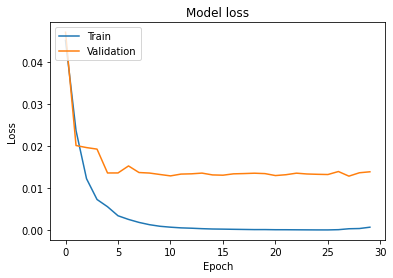

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
model.save('anrp-regression-model.h5')

In [ ]:
%cd ..

/content/drive/MyDrive


In [ ]:
from tensorflow import keras

In [ ]:
model = keras.models.load_model('anrp-regression-model.h5')

In [ ]:
model.summary()

In [ ]:
y_hat = model.predict(test_generator) *WIDTH

In [ ]:
test_ann=[]

In [ ]:
for idx, row in test_data.iterrows():     
  test_ann.append([row[1],row[2],row[3],row[4]])
 

In [ ]:

test_ann


In [ ]:
test_ann=np.array(test_ann)*WIDTH

In [ ]:
test_ann

In [ ]:
def view_bbox(index):
    img = cv2.resize(cv2.imread("Indian/"+test_data['image_name'].iloc[index]) / 255.0, dsize=(WIDTH, HEIGHT))
    pred = model.predict(img.reshape(1, WIDTH, HEIGHT, 3)).reshape(-1) * WIDTH
    print(pred)

    pxt, pyt = pred[0], pred[1]
    pxb, pyb = pred[2], pred[3]
    ground_t=np.array(test_ann[index])
    gxt, gyt = ground_t[0], ground_t[1]
    gxb, gyb = ground_t[2], ground_t[3]
    print(ground_t)
    img = cv2.cvtColor(img.astype(np.float32), cv2.COLOR_BGR2RGB)
    image = cv2.rectangle(img, (pxt, pyt), (pxb, pyb), (0, 0, 255), 1)
    image = cv2.rectangle(img, (int(gxt), int(gyt)), (int(gxb), int(gyb)), (255, 0, 0), 1)
    plt.imshow(image)
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 21.931536  38.27315  214.85628  174.91682 ]
[  9.07341772  28.95238095 208.12151899 192.        ]


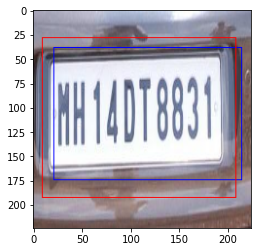

In [ ]:
view_bbox(16)

In [ ]:
def intersection_over_union(gt_box, pred_box):
    inter_box_top_left = [max(gt_box[0], pred_box[0]), max(gt_box[1], pred_box[1])]
    inter_box_bottom_right = [min(gt_box[0]+gt_box[2], pred_box[0]+pred_box[2]), min(gt_box[1]+gt_box[3], pred_box[1]+pred_box[3])]

    inter_box_w = inter_box_bottom_right[0] - inter_box_top_left[0]
    inter_box_h = inter_box_bottom_right[1] - inter_box_top_left[1]
    print(inter_box_w,inter_box_h)
    intersection = inter_box_w * inter_box_h
    union = gt_box[2] * gt_box[3] + pred_box[2] * pred_box[3] - intersection
    
    iou = intersection / union

    return iou,(intersection/(WIDTH*WIDTH))

In [ ]:
intersection_over_union([  9.07341772 , 28.95238095 ,208.12151899, 192.        ],[ 21.931536 , 38.27315 , 214.85628 , 174.91682 ])

195.26340071 174.91682000000003


(0.7872238581307958, 0.6807009947899185)

In [ ]:
def get_bbox(index):
    img = cv2.resize(cv2.imread("Indian/"+test_data['image_name'].iloc[index]) / 255.0, dsize=(WIDTH, HEIGHT))
    pred = model.predict(img.reshape(1, WIDTH, HEIGHT, 3)).reshape(-1) * WIDTH
    return pred

In [ ]:
pred_scores=[]
pred_l=[]

In [ ]:
for i in range(0,len(test_data)):
  print("---",i,"----")
  iou,inter=intersection_over_union(test_ann[i], get_bbox(i))
  pred_scores.append(iou)
  pred_l.append(inter)
  

--- 0 ----
95.62141896663096 143.74241943359357
--- 1 ----
136.39868 175.1233673773873
--- 2 ----
148.328 175.42655857762077
--- 3 ----
144.40042041015627 180.70071
--- 4 ----
175.727441887668 139.26837158203105
--- 5 ----
150.47890869140628 145.62680667168632
--- 6 ----
149.6310542602539 104.76430050040409
--- 7 ----
104.7348538208008 182.46324
--- 8 ----
163.04581959240076 152.79623
--- 9 ----
156.29055698279177 166.47458
--- 10 ----
159.24579 180.59455320059504
--- 11 ----
96.26564562081313 164.5373254879745
--- 12 ----
142.97239990234377 164.05994
--- 13 ----
132.68032800292968 130.87460757877028
--- 14 ----
124.48517712402344 165.77815
--- 15 ----
82.2382541174774 159.7264332843328
--- 16 ----
195.26340098803536 174.91682


In [ ]:
pred_scores

In [ ]:
pred_l

[0.27393283864670054,
 0.4760562108327181,
 0.5185879921605215,
 0.5200346597196117,
 0.4877486183428634,
 0.43673794132991395,
 0.3124201357763375,
 0.3808645753797055,
 0.4965080362025336,
 0.5185428223274505,
 0.5731609143143626,
 0.31567466252434906,
 0.46747534384131934,
 0.34607154537639406,
 0.411290710160256,
 0.26179095602908287,
 0.6807010126517725]

In [ ]:
pred_l_n=[1 if score >= .35 else 0 for score in pred_l]

In [ ]:
pred_l_n

[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1]

In [ ]:
from collections import Counter
d = Counter(pred_l_n)
d[0]


5

In [ ]:
d[1]

15

In [ ]:
true_y=[1 for i in range(0,17)]

In [ ]:
%pwd

In [ ]:
import numpy
import sklearn.metrics

In [ ]:
fn=d[0]

In [ ]:
fn

2

In [ ]:
def precision_recall_curve(y_true, pred_scores, thresholds):
    precisions = []
    recalls = []
    
    for threshold in thresholds:
        y_pred = [1 if score >= threshold else 0 for score in pred_scores]
        r = numpy.flip(sklearn.metrics.confusion_matrix(y_true, y_pred))
        tp=r[0][0]
        fp=r[0][1]
        
        print(y_true)
        print(y_pred)
        print(r)
        print(tp,fp)
        # precision = sklearn.metrics.precision_score(y_true=y_true, y_pred=y_pred, pos_label=1)
        # recall = sklearn.metrics.recall_score(y_true=y_true, y_pred=y_pred, pos_label=1)
        precision = tp/(tp+fp)
        recall = tp/(tp+fn)
        
        precisions.append(precision)
        recalls.append(recall)
    
    return precisions, recalls

In [ ]:
thresholds = numpy.arange(start=0.5, stop=0.9, step=0.05)

In [ ]:
precisions, recalls = precision_recall_curve(y_true=true_y, 
                                             pred_scores=pred_scores, 
                                             thresholds=thresholds)

In [ ]:
precisions,recalls

In [ ]:
precisions = numpy.array(precisions)
recalls = numpy.array(recalls)

In [ ]:
recalls[:-1]

array([], dtype=float64)

In [ ]:
mAP = numpy.sum((recalls[:-1] - recalls[1:]) * precisions[:-1])
print(mAP)

0.18993369032068722


In [ ]:
precisions, recalls = precision_recall_curve(y_true=true_y, 
                                             pred_scores=pred_scores, 
                                             thresholds=thresholds)

0.4448529411764706

In [ ]:
precisions, recalls = precision_recall_curve(y_true=true_y, 
                                             pred_scores=pred_scores,
                                             thresholds=[.5])

In [ ]:
precisions = numpy.array(precisions)
recalls = numpy.array(recalls)

In [ ]:
precisions*recalls

array([0.66176471])